In [52]:
import time
import torch
import matplotlib.pyplot as plt

import escnn.nn as enn
import escnn.gspaces as gspaces

from molnet.escnn_models import MaskModule3D

from itertools import product, repeat
import math


In [53]:
x = torch.rand(4, 1, 32, 32, 32)

r2_act = gspaces.rot2dOnR3(n=-1)
in_type = enn.FieldType(r2_act, [r2_act.trivial_repr])
print(in_type.gspace.dimensionality)
x = in_type(x)

3


Time: 0.000598907470703125
torch.Size([4, 1, 32, 32, 32])


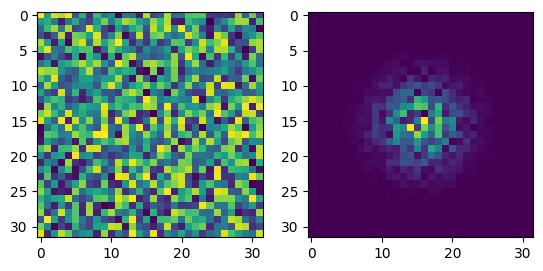

In [54]:
mask = enn.MaskModule(in_type, 32, margin=2, sigma=5)
t0 = time.time()
y = mask(x)
print('Time:', time.time() - t0)

print(y.shape)
ax = plt.subplot(1, 2, 1)
ax.imshow(x.tensor[0,0,...,-1].detach().numpy())

ax = plt.subplot(1, 2, 2)
ax.imshow(y.tensor[0,0,...,-1].detach().numpy())

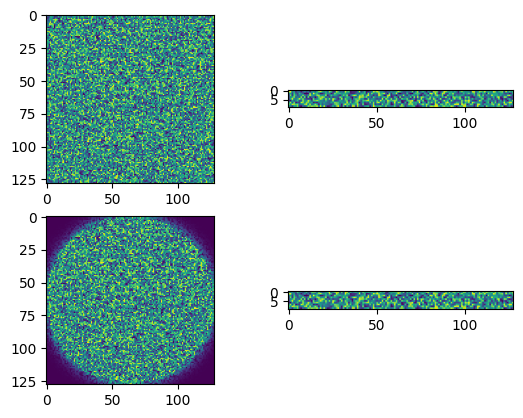

In [55]:
sh = (128, 128, 10)
mask_fn = MaskModule3D(in_type, sh, margin=0, sigma=20)
x = torch.rand(4, 1, *sh)
x = in_type(x)
y = mask_fn(x)

x = x.tensor
y = y.tensor

ax = plt.subplot(2, 2, 1)
ax.imshow(x[0, 0, ..., 0].detach().numpy())

ax = plt.subplot(2, 2, 2)
ax.imshow(x[0, 0, ..., 64, :].T.detach().numpy())

ax = plt.subplot(2, 2, 3)
ax.imshow(y[0, 0, ..., 0].detach().numpy())

ax = plt.subplot(2, 2, 4)
ax.imshow(y[0, 0, ..., 64, :].T.detach().numpy())

In [56]:
x = torch.rand(4, 1, 32, 32, 32)

r2_act = gspaces.rot2dOnR3(n=4)
in_type = enn.FieldType(r2_act, [r2_act.trivial_repr])
out_type = enn.FieldType(r2_act, [r2_act.regular_repr]*8)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.in_type = in_type
        self.conv = enn.R3Conv(
            in_type=in_type,
            out_type=out_type,
            kernel_size=5,
            padding=2
        )
        self.conv2 = enn.R3Conv(
            in_type=out_type,
            out_type=out_type,
            kernel_size=5,
            padding=2
        )
    
    def forward(self, x):
        x = self.in_type(x)
        x = self.conv(x)
        x = self.conv2(x)
        x = x.tensor
        return x
    
model = Model()

In [57]:
y = model(x)
print(f"x.shape: {x.shape}")
print(f"y.shape: {y.shape}")

x.shape: torch.Size([4, 1, 32, 32, 32])
y.shape: torch.Size([4, 32, 32, 32, 32])


In [75]:
def get_summary(model):
    summary = {}
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    for name, module in model.named_children():
        parameters = sum(p.numel() for p in module.parameters() if p.requires_grad)
        summary[name] = parameters

        print(f"{name}: {parameters}")

    print(f"Total: {total}")

    return summary

In [77]:
summary = get_summary(model)

conv: 160
conv2: 4872
Total: 5032
